# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [1]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (5.0, 6.25)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
coco=COCO("./annotations/instances_train2017.json")

loading annotations into memory...
Done (t=19.87s)
creating index...
index created!


In [3]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['vehicle', 'food', 'appliance', 'kitchen', 'animal', 'outdoor', 'furniture', 'indoor', 'electronic', 'sports', 'person', 'accessory']


In [4]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'a

In [6]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person', 'skateboard']
filterClasses2 = ['person', 'baseball bat']
filterClasses3 = ['person', 'tennis racket']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
catIds2 = coco.getCatIds(catNms=filterClasses2)
catIds3 = coco.getCatIds(catNms=filterClasses3)
# Get all images containing the above Category IDs
imgIdss = coco.getImgIds(catIds=catIds) + coco.getImgIds(catIds=catIds2) +coco.getImgIds(catIds=catIds3)
print("Number of images containing all the  classes:", len(imgIdss))

Number of images containing all the  classes: 9255


In [7]:
import random
random.shuffle(imgIdss)

In [13]:
annFile = "./annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!


A black and white photo of a young man holding a tennis racquete,
A tennis player posing on court for a photograph.
Old picture of tennis player on court with racket.
a guy in all white posing with a tennis racket
A man standing on top of a tennis court holding a racquet.


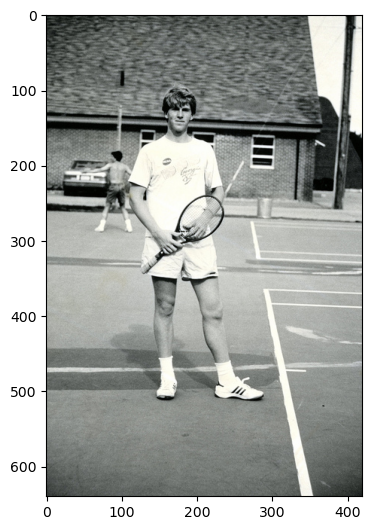

In [16]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id'])
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

In [17]:
print("Total images for training: ", len(imgIdss))

Total images for training:  9255


In [18]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]

        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
print('Cap', imgcaptions)
print("Length of Dataset: ",len(dataset))

Cap ['<start> a man hitting a baseball with a bat next to home plate <end>', '<start> a man hitting a baseball with a bat on a field <end>', '<start> a baseball player hitting a base ball that was pitched to him <end>', '<start> a batter and catcher during a baseball game <end>', '<start> a man swings a bat on a baseball field <end>']
Length of Dataset:  9251


In [19]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Tennis ID: ", tokenizer.word_index['dog'])
print("Baseball ID: ", tokenizer.word_index['ride'])

print(tokenizer.word_index)

Vocabulary length:  5378
Tennis ID:  184
Baseball ID:  273
{'<oov>': 1, 'a': 2, 'end': 3, 'start': 4, 'tennis': 5, 'on': 6, 'the': 7, 'man': 8, 'in': 9, 'baseball': 10, 'is': 11, 'skateboard': 12, 'of': 13, 'with': 14, 'ball': 15, 'player': 16, 'to': 17, 'court': 18, 'at': 19, 'and': 20, 'holding': 21, 'bat': 22, 'his': 23, 'racket': 24, 'playing': 25, 'young': 26, 'game': 27, 'woman': 28, 'riding': 29, 'boy': 30, 'skate': 31, 'person': 32, 'standing': 33, 'swinging': 34, 'hit': 35, 'trick': 36, 'people': 37, 'skateboarder': 38, 'racquet': 39, 'two': 40, 'doing': 41, 'while': 42, 'air': 43, 'field': 44, 'board': 45, 'down': 46, 'up': 47, 'batter': 48, 'ramp': 49, 'an': 50, 'are': 51, 'park': 52, 'ready': 53, 'white': 54, 'swing': 55, 'that': 56, 'players': 57, 'during': 58, 'street': 59, 'hitting': 60, 'jumping': 61, 'group': 62, 'shirt': 63, 'men': 64, 'for': 65, 'skateboarding': 66, 'as': 67, 'top': 68, 'wearing': 69, 'girl': 70, 'plate': 71, 'her': 72, 'black': 73, 'catcher': 74, 'n

# Preprocess and caching the features extracted from InceptionV3

We will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer. This is also called a tranfer learning.

Since the Xception model was originally built for **imagenet**, we will do little changes for integrating with our model. Here, the Xception model takes **100 x 100 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

In [20]:
import pickle

with open("image_features.pickle", "rb") as f:
    image_features = pickle.load(f)

In [ ]:
model = Xception(include_top=False, pooling='avg')

image_features = {}

for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

In [21]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

51

# Make a Data Generator

We have to train our model on 9251 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 9251 images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

In [22]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure



* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [23]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model


In [12]:
# train our model
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs=1
steps = len(dataset)

# making a directory models to save our models
import os
os.mkdir("models")

for i in range(epochs):
    generator = data_generator(dataset, image_features, tokenizer, max_length)
    model.fit(generator, epochs=15, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  9251
Descriptions: train= 9251
Photos: train= 9251
Vocabulary Size: 5378
Description Length:  51
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 51, 256)      1376768     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']    

In [21]:
model.save("models/model_0.h5")

In [ ]:
folder_path = "./vali/"
files = os.listdir(folder_path)

In [ ]:
coco_val = COCO('./annotations/captions_val2017.json')
img_ides = [f.split('.')[0] for f in files]
gtc = {} #Ground Truth 
for img_id in img_ides:
    img_id=int(img_id)
    ann_ids = coco_val.getAnnIds(imgIds=img_id)
    captions = [coco_val.anns[ann_id]['caption'] for ann_id in ann_ids]
    gtc[str(int(img_id))] = captions
with open('gtc.json', 'w') as f:
    json.dump(gtc, f)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [ ]:
capti = {}
for file in files:
    img_path=folder_path+file
    photo = extract_features(img_path, xception_model)
    desc = return_caps(img_path)
    capti[str(int(file.split('.')[0]))] = desc
with open('generated_captions.json', 'w') as f:
    json.dump(capti, f)

In [ ]:
import json

new_cap = []
for k, v in capti.items():
    new_cap.append({'image_id': k, 'caption': v})

new_ref = {'images': [], 'annotations': []}
for k, refs in gtc.items():
    new_ref['images'].append({'id': k})
    for ref in refs:
        new_ref['annotations'].append({'image_id': k, 'id': k, 'caption': ref})

with open('references.json', 'w') as fgtc:
    json.dump(new_ref, fgtc)
with open('captions.json', 'w') as fres:
    json.dump(new_cap, fres)

In [ ]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = 'references.json'
results_file = 'captions.json'

In [ ]:
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

coco_eval = COCOEvalCap(coco, coco_result)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


### Evaluate the model using Cocoevalcap API

In [ ]:
coco_eval.params['image_id'] = coco_result.getImgIds()
coco_eval.evaluate()

for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 2765, 'reflen': 2785, 'guess': [2765, 2465, 2165, 1865], 'correct': [2018, 1040, 449, 200]}
ratio: 0.9928186714538626
Bleu_1: 0.725
Bleu_2: 0.551
Bleu_3: 0.397
Bleu_4: 0.286
computing METEOR score...
METEOR: 0.269
computing Rouge score...
ROUGE_L: 0.554
computing CIDEr score...
CIDEr: 0.590
Bleu_1: 0.725
Bleu_2: 0.551
Bleu_3: 0.397
Bleu_4: 0.286
METEOR: 0.269
ROUGE_L: 0.554
CIDEr: 0.590


The Scores are as follows:

![Scores](scores.png)

### Test the model on random test images
The images are downloaded for various sources on the web

Generated Captions: a man holding a tennis racquet on a tennis court


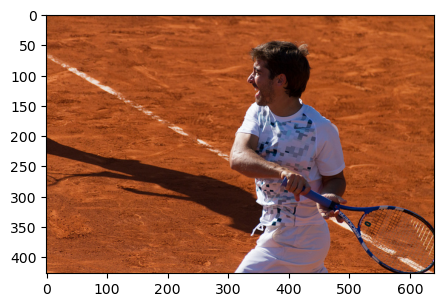

Generated Captions: a baseball player swinging a bat on a field


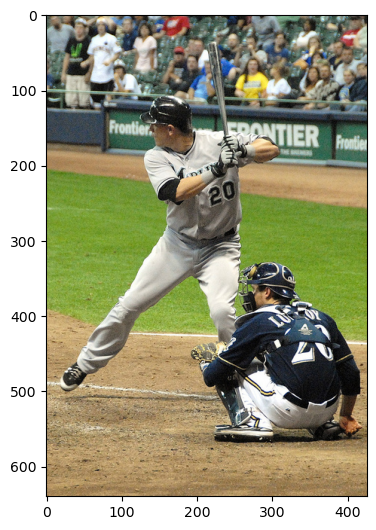

Generated Captions: a man riding a skateboard down a ramp


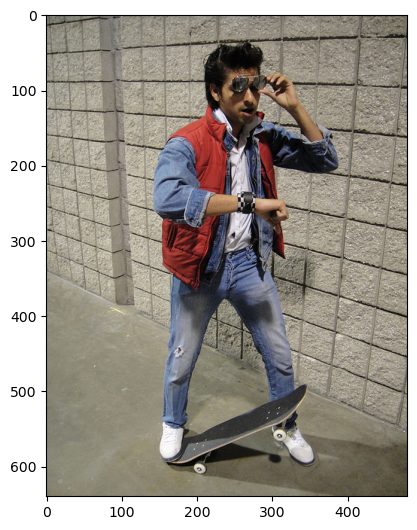

Generated Captions: a man holding a tennis racquet on a tennis court


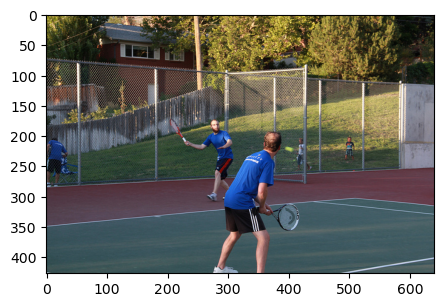

Generated Captions: a man riding a skateboard down a stance rail


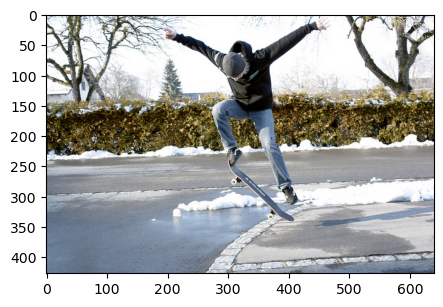

Generated Captions: a baseball player swinging a bat on a field


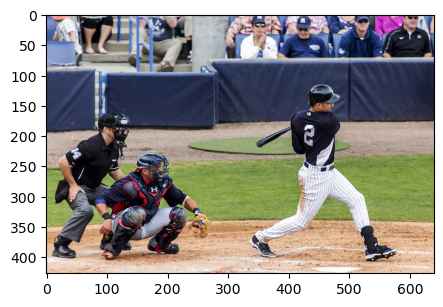

Generated Captions: a man is playing tennis on a court


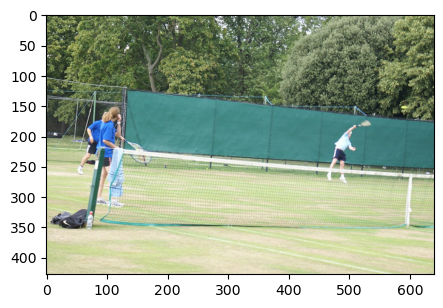

Generated Captions: a man riding a skateboard down a stance rail


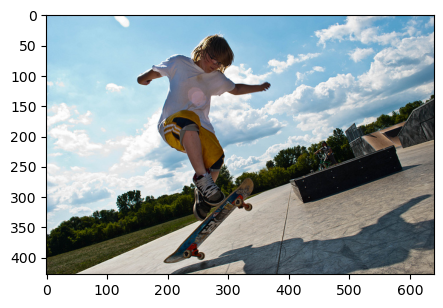

Generated Captions: a woman is playing tennis on a court


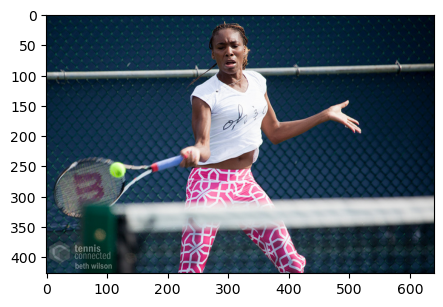

Generated Captions: a man riding a skateboard down a street


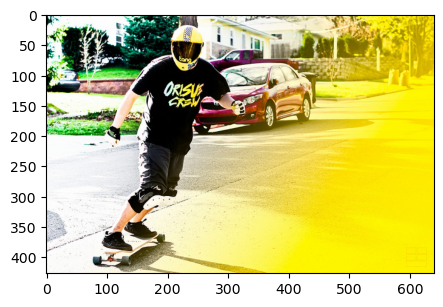

In [ ]:
folder_path = "./testing"
img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]
for img_path in img_paths:
    generate_caps(img_path)